## Leer datos

In [1]:
!pip install -q polars

In [2]:
import polars as pl
import boto3
import os
from botocore.exceptions import NoCredentialsError, ClientError

def download_from_s3_and_read(bucket_name, s3_key, local_filename='temp_file.csv', 
                             aws_profile=None, region_name='us-east-1'):
    """
    Descarga un archivo desde S3 y lo lee con Polars de manera lazy
    
    Args:
        bucket_name (str): Nombre del bucket de S3
        s3_key (str): Ruta del archivo en S3 (ej: 'data/credir_risk_reto.csv')
        local_filename (str): Nombre temporal local para el archivo
        region_name (str): Región de AWS
    
    Returns:
        polars.LazyFrame: DataFrame lazy de Polars
    """
    
    try:
        # Crear sesión de boto3
        if aws_profile:
            session = boto3.Session(profile_name=aws_profile)
            s3_client = session.client('s3', region_name=region_name)
        else:
            s3_client = boto3.client('s3', region_name=region_name)
        
        # Descargar archivo desde S3
        print(f"Descargando {s3_key} desde el bucket {bucket_name}...")
        s3_client.download_file(bucket_name, s3_key, local_filename)
        print(f"Archivo descargado como {local_filename}")
        
        # Leer el archivo de manera LAZY directamente desde el disco
        df_lazy_initial = pl.scan_csv(local_filename, separator=';')
        
        return df_lazy_initial
        
    except NoCredentialsError:
        print("Error: Credenciales de AWS no encontradas")
        raise
    except ClientError as e:
        print(f"Error de cliente AWS: {e}")
        raise
    except Exception as e:
        print(f"Error inesperado: {e}")
        raise


In [3]:
BUCKET_NAME = 'credit-risk-pipeline-preauth-prod-us-east-1-nxhm2'
S3_KEY = 'data/raw/credir_risk_reto.csv'  # Archivo específico
LOCAL_FILE = 'credir_risk_reto.csv'

# Descargar y leer el archivo desde S3
df_lazy_initial = download_from_s3_and_read(
    bucket_name=BUCKET_NAME,
    s3_key=S3_KEY,
    local_filename=LOCAL_FILE,
    region_name='us-east-1' 
)

Descargando data/raw/credir_risk_reto.csv desde el bucket credit-risk-pipeline-preauth-prod-us-east-1-nxhm2...
Archivo descargado como credir_risk_reto.csv


## Feature Engineer
Agregar datos extra apartir de los existentes
*  Sacar un ratio de la deuda entre ahorros
*  Sacar el pago mensual (sin intereses)

In [4]:
def create_engineered_features_lazy(df_lazy: pl.LazyFrame) -> pl.LazyFrame:
    """
    Toma un LazyFrame, añade los pasos para crear nuevas características al
    plan de consulta, y devuelve el nuevo LazyFrame sin ejecutar nada.
    """
    print("--- AÑADIENDO PASO DE INGENIERÍA DE CARACTERÍSTICAS AL PLAN LAZY ---")
    
    account_map = {'no info': 0, 'little': 1, 'moderate': 2, 'rich': 3}

    # Aplicamos with_columns a un LazyFrame. Esto no calcula nada,
    # solo añade la operación al plan.
    df_engineered_lazy = df_lazy.with_columns([
        (pl.col('Credit amount') / pl.col('Duration')).alias('monthly_payment'),
        (pl.col('Credit amount') / (pl.col('Saving accounts').replace_strict(account_map, default=0) + 1)).alias('debt_to_savings_ratio')
    ])
    
    print("✅ Paso de ingeniería de características añadido al plan.")
    return df_engineered_lazy

In [5]:
df_incomplete_engineered = create_engineered_features_lazy(df_lazy_initial)

--- AÑADIENDO PASO DE INGENIERÍA DE CARACTERÍSTICAS AL PLAN LAZY ---
✅ Paso de ingeniería de características añadido al plan.


## Pipeline FULL API
El LLM que se usa para crear la descripción, se usa para clasificar (generar las etiquetas "bad risk" y "good risk"). Así se reduce los costes de tener un modelo en local y es más rápido procesar.


In [23]:
import polars as pl
import asyncio
import nest_asyncio
import functools
import json
import gc
import re
from concurrent.futures import ThreadPoolExecutor
import boto3
from botocore.exceptions import ClientError

nest_asyncio.apply()

# --- CONFIGURACIÓN DEL CLIENTE BEDROCK ---
def create_bedrock_client(region_name='us-east-1'):
    """Crea y retorna el cliente de Bedrock"""
    try:
        bedrock_client = boto3.client(
            service_name='bedrock-runtime',
            region_name=region_name
        )
        print("✅ Cliente Bedrock creado exitosamente")
        return bedrock_client
    except Exception as e:
        print(f"❌ Error creando cliente Bedrock: {e}")
        raise

# Crear cliente Bedrock
bedrock_client = create_bedrock_client()
model_id = "amazon.nova-lite-v1:0"  # Modelo Nova Lite

# --- PROMPT PARA PROCESAMIENTO POR LOTES ---
PROMPT_BATCH = """
Act as a senior credit risk analyst. I will provide you with a list of clients. For each client in the list, perform two tasks:
1.  Generate a concise, objective credit risk profile description (approx. 200 characters).
2.  Classify the profile as either "good risk" or "bad risk".

Here is the list of clients to process:
{client_data_batch}

Provide the output *only* as a single, valid JSON array where each element is an object corresponding to a client in the list. Maintain the original order.
Example for a list of 2 clients:
[
  {{
    "description": "Description for client 1...",
    "risk_label": "good risk"
  }},
  {{
    "description": "Description for client 2...",
    "risk_label": "bad risk"
  }}
]
"""

def _format_batch_for_prompt(batch_of_dicts: list[dict]) -> str:
    """Formatea una lista de registros de clientes para inyectarla en el prompt."""
    formatted_strings = []
    for i, row in enumerate(batch_of_dicts):
        s = (f"Client {i+1}: Age={row['Age']}, Sex={row['Sex']}, Job={row['Job']}, Housing={row['Housing']}, "
             f"Saving accounts={row['Saving accounts']}, Checking account={row['Checking account']}, "
             f"Credit amount={row['Credit amount']}, Duration={row['Duration']} months, Purpose={row['Purpose']}"
            f"Monthly Payment={row['monthly_payment']}, Debt to Savings Ratio={row['debt_to_savings_ratio']}")
        formatted_strings.append(s)
    return "\n".join(formatted_strings)

def _extract_json_array_from_response(text: str) -> str | None:
    if not text: return None
    match = re.search(r'\[.*\]', text, re.DOTALL)
    if match: return match.group(0)
    return None

async def _process_records_batch_async(batch_of_dicts: list[dict], semaphore: asyncio.Semaphore, executor: ThreadPoolExecutor, client, model_id: str) -> list[dict]:
    """Toma un lote de registros, los envía en una sola llamada y procesa la respuesta usando Bedrock Converse."""
    client_data_str = _format_batch_for_prompt(batch_of_dicts)
    prompt = PROMPT_BATCH.format(client_data_batch=client_data_str)
    error_payload = [{"description": "Error en lote", "risk_label": "Error en lote"} for _ in batch_of_dicts]

    async with semaphore:
        loop = asyncio.get_running_loop()
        try:
            # Preparar el mensaje para Bedrock Converse API
            messages = [
                {
                    "role": "user",
                    "content": [{"text": prompt}]
                }
            ]
            
            # Configuración para la llamada a converse
            converse_params = {
                "modelId": model_id,
                "messages": messages,
                "inferenceConfig": {
                    #"maxTokens": 8000,
                    "temperature": 0.1,
                    "topP": 0.9
                }
            }
            
            # Ejecutar la llamada de forma asíncrona
            converse_func = functools.partial(client.converse, **converse_params)
            response = await loop.run_in_executor(executor, converse_func)
            
            # --- LÓGICA DE PROCESAMIENTO DE RESPUESTA BEDROCK ---
            
            # 1. Comprobar si la respuesta es válida
            if not response:
                return [{"description": "Respuesta nula de Bedrock", "risk_label": "Error API"} for _ in batch_of_dicts]

            # 2. Comprobar si hay un error de stop reason
            stop_reason = response.get('stopReason', '')
            if stop_reason in ['content_filtered', 'guardrail_intervened']:
                return [{"description": f"Bloqueado: {stop_reason}", "risk_label": "Error Seguridad"} for _ in batch_of_dicts]
            
            # 3. Intentar obtener el texto de la respuesta
            raw_text = ""
            try:
                output = response.get('output', {})
                message = output.get('message', {})
                content = message.get('content', [])
                
                if content and len(content) > 0:
                    raw_text = content[0].get('text', '')
                
            except Exception as e:
                print(f"Error extrayendo texto de respuesta: {e}")
                return error_payload
            
            # 4. Procesar el texto si lo obtuvimos
            if raw_text:
                json_text = _extract_json_array_from_response(raw_text)
                if json_text:
                    try:
                        parsed_data = json.loads(json_text)
                        if isinstance(parsed_data, list) and len(parsed_data) == len(batch_of_dicts):
                            return parsed_data
                    except json.JSONDecodeError as e:
                        print(f"Error parsing JSON: {e}")
                        return error_payload
            
            # Si ninguna de las condiciones anteriores se cumple, devolvemos un error
            return error_payload

        except ClientError as e:
            error_code = e.response['Error']['Code']
            return [{"description": f"Error Bedrock {error_code}: {e}", "risk_label": "Error API"} for _ in batch_of_dicts]
        except Exception as e:
            return [{"description": f"Error en API: {e}", "risk_label": "Error en API"} for _ in batch_of_dicts]

def run_batch_pipeline_bedrock(df: pl.DataFrame, batch_api_size: int, max_concurrent_calls: int, client, model_id: str) -> pl.DataFrame:
    """Orquesta todo el pipeline usando Bedrock Nova Lite con Converse API."""
    print(f"--- INICIANDO PIPELINE POR LOTES CON BEDROCK NOVA LITE ---")
    print(f"Modelo: {model_id}")
    
    async def main_async_logic():
        all_records = df.to_dicts()
        record_batches = [all_records[i:i + batch_api_size] for i in range(0, len(all_records), batch_api_size)]
        print(f"INFO: Se procesarán {len(all_records)} registros en {len(record_batches)} llamadas a la API.")
        
        semaphore = asyncio.Semaphore(max_concurrent_calls)
        with ThreadPoolExecutor(max_workers=max_concurrent_calls) as executor:
            tasks = [_process_records_batch_async(batch, semaphore, executor, client, model_id) for batch in record_batches]
            results_list_of_lists = await asyncio.gather(*tasks)
        
        final_results = [item for sublist in results_list_of_lists for item in sublist]
        descriptions = [res.get("description", "Error de Parseo") for res in final_results]
        targets = [res.get("risk_label", "Error de Parseo") for res in final_results]
        
        return df.with_columns([pl.Series("description", descriptions), pl.Series("target", targets)])

    final_df = asyncio.run(main_async_logic())
    gc.collect()
    print("\n✅ ¡PIPELINE COMPLETADO CON BEDROCK!")
    return final_df



✅ Cliente Bedrock creado exitosamente


### Ejecutar el pipeline

In [24]:
try:
    # Se dejo en 20 porque no ha dado errores (35-50-100 si daban)
    final_df_generated = run_batch_pipeline_bedrock(
        df=df_incomplete_engineered.collect(),
        batch_api_size=20,         # Cuántos registros enviar en CADA llamada a la API.
        max_concurrent_calls=5,    # Cuántas llamadas a la API hacer en paralelo.
        client=bedrock_client,
        model_id=model_id
    )

    print("\n--- Vista Previa del DataFrame Final ---")
    print(final_df_generated.head())

    error_count = final_df_generated.filter(pl.col('target').str.contains("Error")).height
    if error_count > 0:
        print(f"\n❌ ADVERTENCIA: Se encontraron {error_count} filas con errores de procesamiento.")
        print("Muestra de filas con errores:")
        print(final_df_generated.filter(pl.col('target').str.contains("Error")).head())
    else:
        print("\n✅ ÉXITO: Todas las filas fueron procesadas sin errores aparentes.")

except Exception as e:
    print(f"\n❌ ERROR: El pipeline falló. Causa: {e}")

--- INICIANDO PIPELINE POR LOTES CON BEDROCK NOVA LITE ---
Modelo: amazon.nova-lite-v1:0
INFO: Se procesarán 1000 registros en 50 llamadas a la API.

✅ ¡PIPELINE COMPLETADO CON BEDROCK!

--- Vista Previa del DataFrame Final ---
shape: (5, 13)
┌─────┬────────┬─────┬─────────┬───┬───────────────────┬──────────────────┬─────────────┬──────────┐
│ Age ┆ Sex    ┆ Job ┆ Housing ┆ … ┆ monthly_payment   ┆ debt_to_savings_ ┆ description ┆ target   │
│ --- ┆ ---    ┆ --- ┆ ---     ┆   ┆ ---               ┆ ratio            ┆ ---         ┆ ---      │
│ i64 ┆ str    ┆ i64 ┆ str     ┆   ┆ f64               ┆ ---              ┆ str         ┆ str      │
│     ┆        ┆     ┆         ┆   ┆                   ┆ f64              ┆             ┆          │
╞═════╪════════╪═════╪═════════╪═══╪═══════════════════╪══════════════════╪═════════════╪══════════╡
│ 67  ┆ male   ┆ 2   ┆ own     ┆ … ┆ 194.833333        ┆ 1169.0           ┆ 67-year-old ┆ bad risk │
│     ┆        ┆     ┆         ┆   ┆              

### Guarda el Dataframe sin preprocesar

In [39]:
import polars as pl

s3_file_name = "final_descriptions_targets_extra_features.csv" 
s3_key_path = f"data/processed/{s3_file_name}"

# Crea la URI (Uniform Resource Identifier) completa para S3.
output_s3_uri = f"s3://{BUCKET_NAME}/{s3_key_path}"

print(f"Intentando guardar el DataFrame en S3 en la ruta: {output_s3_uri}")

try:
    final_df_generated.write_csv(output_s3_uri)
    print(f"DataFrame guardado exitosamente en S3: {output_s3_uri}")

except Exception as e:
    print(f"Error al intentar guardar directamente en S3 con Polars: {e}")
    print("Verifica que las librerías 'fsspec' y 's3fs' estén instaladas y que el rol de SageMaker tenga permisos de escritura en el bucket y la ruta especificada.")

Intentando guardar el DataFrame en S3 en la ruta: s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/data/processed/final_descriptions_targets_extra_features.csv
DataFrame guardado exitosamente en S3: s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/data/processed/final_descriptions_targets_extra_features.csv


## Preprocesamiento
Lee el dataframe/csv, preprocesa la información y la divide en train y test

In [27]:
import polars as pl

df_encoded_for_ml = final_df_generated

print("DataFrame cargado como LazyFrame:")
print(df_encoded_for_ml.head())
print(df_encoded_for_ml.schema)

DataFrame cargado como LazyFrame:
shape: (5, 13)
┌─────┬────────┬─────┬─────────┬───┬───────────────────┬──────────────────┬─────────────┬──────────┐
│ Age ┆ Sex    ┆ Job ┆ Housing ┆ … ┆ monthly_payment   ┆ debt_to_savings_ ┆ description ┆ target   │
│ --- ┆ ---    ┆ --- ┆ ---     ┆   ┆ ---               ┆ ratio            ┆ ---         ┆ ---      │
│ i64 ┆ str    ┆ i64 ┆ str     ┆   ┆ f64               ┆ ---              ┆ str         ┆ str      │
│     ┆        ┆     ┆         ┆   ┆                   ┆ f64              ┆             ┆          │
╞═════╪════════╪═════╪═════════╪═══╪═══════════════════╪══════════════════╪═════════════╪══════════╡
│ 67  ┆ male   ┆ 2   ┆ own     ┆ … ┆ 194.833333        ┆ 1169.0           ┆ 67-year-old ┆ bad risk │
│     ┆        ┆     ┆         ┆   ┆                   ┆                  ┆ male with   ┆          │
│     ┆        ┆     ┆         ┆   ┆                   ┆                  ┆ stable j…   ┆          │
│ 22  ┆ female ┆ 2   ┆ own     ┆ … ┆ 123.9

In [28]:
pip install --upgrade scikit-learn imblearn matplotlib seaborn 

  Using cached scikit_learn-1.7.1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install --upgrade numexpr>=2.8.4 #numexpr==2.8.4

Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install --upgrade xgboost>=2.1.4


Note: you may need to restart the kernel to use updated packages.


In [12]:
#!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0


In [31]:
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

def prepare_data_for_ml(df: pl.DataFrame, target_col: str = 'target') -> tuple:
    """
    Toma un DataFrame ya enriquecido, lo divide, lo preprocesa y aplica SMOTE.
    """
    print("--- INICIANDO PREPARACIÓN FINAL DE DATOS (PARA MODELADO) ---")

    # --- PASO 1: Dividir los datos ---
    X = df.drop(target_col)
    y = df[target_col]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    print("✅ Datos divididos en conjuntos de entrenamiento, validación y prueba.")

    # --- PASO 2: Definir y entrenar el preprocesador ---
    # Identificamos las columnas por tipo dinámicamente a partir de los datos de entrenamiento
    ordinal_cols = ['Saving accounts', 'Checking account']
    account_order = ['no info', 'little', 'moderate', 'rich']
    text_col = 'description'
    # Las columnas numéricas son todas las columnas de tipo número
    numeric_cols = X_train.select(pl.col(pl.Float64, pl.Int64)).columns
    # Las de OHE son las de texto que no son ni ordinales ni la de descripción
    one_hot_cols = [col for col in X_train.select(pl.col(pl.Utf8, pl.Categorical)).columns if col not in ordinal_cols + [text_col]]
    
    print(f"INFO: Se han identificado {len(numeric_cols)} columnas numéricas.")
    print(f"INFO: Se han identificado {len(one_hot_cols)} columnas para One-Hot Encoding.")

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('ord', OrdinalEncoder(categories=[account_order, account_order], handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols),
            ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), one_hot_cols),
            ('tfidf', TfidfVectorizer(max_features=100, stop_words='english'), text_col)
        ],
        remainder='drop'
    )
    
    # Entrenar y transformar las características X
    X_train_final = preprocessor.fit_transform(X_train)
    X_val_final = preprocessor.transform(X_val)
    X_test_final = preprocessor.transform(X_test)
    print("✅ Características (X) preprocesadas.")

    # --- PASO 3: Codificar el target y aplicar SMOTE ---
    target_encoder = LabelEncoder()
    y_train_final = target_encoder.fit_transform(y_train)
    y_val_final = target_encoder.transform(y_val)
    y_test_final = target_encoder.transform(y_test)
    print("✅ Target (y) codificado a formato binario.")
    
    # Aplicar SMOTE solo a los datos de entrenamiento
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train_final)
    print("✅ SMOTE aplicado al conjunto de entrenamiento.")
    
    print("\n¡PREPARACIÓN COMPLETA! Las variables están listas para ser usadas en tu celda de entrenamiento.")
    
    return (X_train_smote, y_train_smote, X_val_final, y_val_final, 
            X_test_final, y_test_final, preprocessor, target_encoder)



### Preprocesar

In [32]:
df_to_preprocess=df_encoded_for_ml

In [33]:
(
    X_train_smote, y_train_smote,
    X_val_final, y_val_final,
    X_test_final, y_test_final,
    preprocessor, target_encoder
) = prepare_data_for_ml(df_to_preprocess)


--- INICIANDO PREPARACIÓN FINAL DE DATOS (PARA MODELADO) ---
✅ Datos divididos en conjuntos de entrenamiento, validación y prueba.
INFO: Se han identificado 6 columnas numéricas.
INFO: Se han identificado 3 columnas para One-Hot Encoding.
✅ Características (X) preprocesadas.
✅ Target (y) codificado a formato binario.
✅ SMOTE aplicado al conjunto de entrenamiento.

¡PREPARACIÓN COMPLETA! Las variables están listas para ser usadas en tu celda de entrenamiento.


In [34]:
import numpy as np
import joblib
import boto3
from scipy.sparse import save_npz
import os

# Asegúrate de que tus variables (X_train_smote, etc.) y BUCKET_NAME existan

PROCESSED_DATA_PREFIX = "data/processed/"
MODEL_ARTIFACTS_PREFIX = "model_artifacts/"
s3_client = boto3.client('s3')

data_to_save = {
    "X_train_smote": (X_train_smote, save_npz),
    "y_train_smote": (y_train_smote, np.save),
    "X_val_final":   (X_val_final, save_npz),
    "y_val_final":   (y_val_final, np.save),
    "X_test_final":  (X_test_final, save_npz),
    "y_test_final":  (y_test_final, np.save),
    "preprocessor":  (preprocessor, joblib.dump),
    "target_encoder": (target_encoder, joblib.dump),
}

# Lista para guardar las rutas de los archivos locales creados
local_files_created = []

try:
    print("--- Guardando datos preprocesados y transformadores en S3 ---")
    for name, (obj, saver) in data_to_save.items():
        
        # 1. Lógica mejorada para determinar la extensión y la ruta
        if saver == save_npz:
            ext = ".npz"
            prefix = PROCESSED_DATA_PREFIX
        elif saver == np.save:
            ext = ".npy"
            prefix = PROCESSED_DATA_PREFIX
        elif saver == joblib.dump:
            ext = ".joblib"
            prefix = MODEL_ARTIFACTS_PREFIX
        else:
            # Salvaguarda por si se añade un nuevo tipo de guardado
            raise TypeError(f"El guardador para '{name}' no es reconocido.")

        local_path = f"/tmp/{name}{ext}"
        s3_key = f"{prefix}{name}{ext}"
        local_files_created.append(local_path) # Añadir a la lista para limpieza

        # 2. Llamada correcta a las funciones de guardado
        if saver == joblib.dump:
            # La sintaxis correcta es: saver(objeto, ruta)
            saver(obj, local_path)
        else:
            # La sintaxis para np.save y save_npz es: saver(ruta, objeto)
            saver(local_path, obj)
            
        s3_client.upload_file(local_path, BUCKET_NAME, s3_key)
        print(f"✅ Guardado {name} en s3://{BUCKET_NAME}/{s3_key}")

    print("\n✅ Todos los archivos guardados exitosamente en S3.")

except (TypeError, Exception) as e:
    print(f"❌ ERROR al guardar archivos en S3: {e}")

finally:
    # 3. Lógica de limpieza mejorada
    print("\n--- Limpiando archivos temporales locales ---")
    for file_path in local_files_created:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"🗑️ Eliminado {file_path}")

--- Guardando datos preprocesados y transformadores en S3 ---
✅ Guardado X_train_smote en s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/data/processed/X_train_smote.npz
✅ Guardado y_train_smote en s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/data/processed/y_train_smote.npy
✅ Guardado X_val_final en s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/data/processed/X_val_final.npz
✅ Guardado y_val_final en s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/data/processed/y_val_final.npy
✅ Guardado X_test_final en s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/data/processed/X_test_final.npz
✅ Guardado y_test_final en s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/data/processed/y_test_final.npy
✅ Guardado preprocessor en s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/model_artifacts/preprocessor.joblib
✅ Guardado target_encoder en s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/model_artifacts/target_encoder.joblib

✅ Todos los a

## Entrenamiento del modelo y validación
Se entrena el modelo XGBOOST con los datos preprocesados y se valida con la información separada

In [35]:
!pip install -q scikit-optimize


## Entrenamiento

In [36]:
# ==============================================================================
# PASO 3: Verificar las versiones instaladas
# ==============================================================================
import sklearn
import xgboost
import skopt

print(f"scikit-learn version: {sklearn.__version__}")
print(f"xgboost version: {xgboost.__version__}")
print(f"scikit-optimize version: {skopt.__version__}")

scikit-learn version: 1.6.1
xgboost version: 3.0.2
scikit-optimize version: 0.10.2


In [37]:
# ==============================================================================
# CELDA 1: ENTRENAMIENTO DEL MODELO CON OPTIMIZACIÓN BAYESIANA
# ==============================================================================
# Responsabilidad: Encontrar los mejores hiperparámetros, entrenar el modelo
# y guardarlo para la siguiente etapa.

# --- Importamos las librerías necesarias ---
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb
import joblib # Necesario para guardar el modelo

# --- Verificamos que los datos de entrenamiento existan ---
if 'X_train_smote' in locals() and 'y_train_smote' in locals():

    # --- PASO 1: Definir el Modelo y el ESPACIO de Búsqueda ---
    xgb_classifier = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    search_spaces = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'max_depth': Integer(2, 8),
        'n_estimators': Integer(50, 300)
    }

    # --- PASO 2: Configurar y Ejecutar la Búsqueda Bayesiana ---
    bayes_search = BayesSearchCV(
        estimator=xgb_classifier,
        search_spaces=search_spaces,
        scoring='f1_macro',
        cv=3,
        n_iter=30,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    print("--- INICIANDO BÚSQUEDA BAYESIANA DE HIPERPARÁMETROS ---")
    bayes_search.fit(X_train_smote, y_train_smote)

    print("\n✅ BÚSQUEDA COMPLETADA.")
    print(f"Mejores Hiperparámetros Encontrados: {bayes_search.best_params_}")
    print(f"Mejor F1-score (macro) en Validación Cruzada: {bayes_search.best_score_:.4f}")

    # --- PASO 3: Guardar el mejor modelo en un archivo ---
    # Este es el puente entre la celda de entrenamiento y la de evaluación.
    best_model = bayes_search.best_estimator_
    model_filename = "best_bayes_xgb_model.joblib"
    joblib.dump(best_model, model_filename)
    
    print(f"\n✅ Mejor modelo guardado localmente como '{model_filename}'")

else:
    print("❌ ERROR: No se encontraron los datos de entrenamiento ('X_train_smote', 'y_train_smote').")

--- INICIANDO BÚSQUEDA BAYESIANA DE HIPERPARÁMETROS ---
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an ol

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:21:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:22:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fo


✅ BÚSQUEDA COMPLETADA.
Mejores Hiperparámetros Encontrados: OrderedDict([('learning_rate', 0.01419912317482973), ('max_depth', 6), ('n_estimators', 219)])
Mejor F1-score (macro) en Validación Cruzada: 0.8608

✅ Mejor modelo guardado localmente como 'best_bayes_xgb_model.joblib'


## Testeo

--- Cargando modelo desde 'best_bayes_xgb_model.joblib' ---

--- EVALUANDO EL MODELO EN EL CONJUNTO DE DATOS ---

Reporte de Clasificación:
              precision    recall  f1-score   support

    bad risk       0.83      0.89      0.86        81
   good risk       0.86      0.78      0.82        69

    accuracy                           0.84       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.84      0.84      0.84       150


Matriz de Confusión:


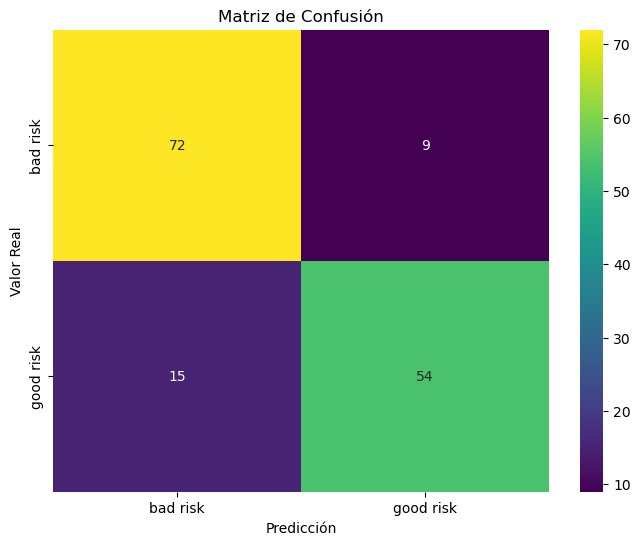


--- Subiendo 'confusion_matrix.png' a S3 ---
✅ Gráfico guardado exitosamente en s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/reports/figures/confusion_matrix.png


In [38]:
import joblib
import boto3
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- Configuración de S3 ---
REPORTS_PREFIX = "reports/figures/" # Carpeta dentro del bucket para los gráficos
model_filename = "best_bayes_xgb_model.joblib"

# --- Verificamos que los datos de validación/prueba existan ---
if 'X_val_final' in locals() and 'y_val_final' in locals() and 'target_encoder' in locals():
    
    # 1. Cargar el modelo entrenado desde el archivo local
    if os.path.exists(model_filename):
        print(f"--- Cargando modelo desde '{model_filename}' ---")
        best_model = joblib.load(model_filename)

        # 2. Realizar predicciones en el conjunto de validación/prueba
        print("\n--- EVALUANDO EL MODELO EN EL CONJUNTO DE DATOS ---")
        y_pred = best_model.predict(X_val_final)

        print("\nReporte de Clasificación:")
        print(classification_report(y_val_final, y_pred, target_names=target_encoder.classes_))

        # 3. Generar la Matriz de Confusión
        print("\nMatriz de Confusión:")
        cm = confusion_matrix(y_val_final, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
                    xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
        plt.xlabel('Predicción')
        plt.ylabel('Valor Real')
        plt.title('Matriz de Confusión')
        
        # Guardar la figura localmente antes de subirla
        local_plot_filename = "confusion_matrix.png"
        plt.savefig(local_plot_filename, dpi=300, bbox_inches='tight')
        plt.show() # Mostrar el gráfico en el notebook

        # 4. Subir el gráfico a S3
        if BUCKET_NAME != "tu-bucket-de-s3-aqui":
            try:
                print(f"\n--- Subiendo '{local_plot_filename}' a S3 ---")
                s3_client = boto3.client('s3')
                s3_key = f"{REPORTS_PREFIX}{local_plot_filename}"
                s3_client.upload_file(local_plot_filename, BUCKET_NAME, s3_key)
                print(f"✅ Gráfico guardado exitosamente en s3://{BUCKET_NAME}/{s3_key}")
            except Exception as e:
                print(f"❌ ERROR al subir el archivo a S3: {e}")
                print("Por favor, verifica el nombre del bucket y tus credenciales de AWS.")
        else:
            print("\n⚠️ ADVERTENCIA: No se subió el gráfico a S3. Por favor, configura tu BUCKET_NAME.")
            
    else:
        print(f"❌ ERROR: El archivo del modelo '{model_filename}' no fue encontrado.")
        print("Asegúrate de ejecutar la Celda 1 (Entrenamiento) primero.")
else:
    print("❌ ERROR: Las variables 'X_val_final', 'y_val_final', o 'target_encoder' no fueron encontradas.")
    print("Por favor, asegúrate de cargar los datos antes de ejecutar esta celda.")

## Guarda el modelo en S3

In [40]:
import boto3
import os

# BUCKET_NAME = 'credit-risk-pipeline-preauth-prod-us-east-1-nxhm2' 

local_model_filename = "best_bayes_xgb_model.joblib"

model_artifacts_prefix = "model_artifacts/"

s3_client = boto3.client('s3')

s3_key_for_model = f"{model_artifacts_prefix}{local_model_filename}"

if os.path.exists(local_model_filename):
    try:
        print(f"Subiendo '{local_model_filename}' a 's3://{BUCKET_NAME}/{s3_key_for_model}'...")
        
        # Subir el archivo
        s3_client.upload_file(local_model_filename, BUCKET_NAME, s3_key_for_model)
        
        print(f"✅ ÉXITO: El modelo fue guardado exitosamente en S3.")
        
    except Exception as e:
        print(f"❌ ERROR al subir el modelo a S3: {e}")
else:
    print(f"❌ ERROR: No se encontró el archivo del modelo '{local_model_filename}' en el directorio local.")
    print("Asegúrate de que la celda de entrenamiento se haya ejecutado correctamente.")

Subiendo 'best_bayes_xgb_model.joblib' a 's3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/model_artifacts/best_bayes_xgb_model.joblib'...
✅ ÉXITO: El modelo fue guardado exitosamente en S3.


In [ ]:
# Despliegue

## Automatiza la creación del ZIP

In [57]:

import os

# --- 1. Configuración ---
# BUCKET_NAME = 'credit-risk-pipeline-preauth-prod-us-east-1-nxhm2'

MODEL_ARTIFACTS_PREFIX = 'model_artifacts/'

LOCAL_DEPLOY_DIR = 'deployment_package'

ARTIFACT_FILES = [
    'best_bayes_xgb_model.joblib',
    'preprocessor.joblib',
    'target_encoder.joblib'
]

TAR_FILENAME = 'model.tar.gz'


# --- 2. Preparación del Entorno Local ---
print("🚀 Iniciando preparación del paquete de despliegue...")
print("1/5: Limpiando entorno de trabajo anterior...")
!rm -rf {LOCAL_DEPLOY_DIR}
!rm -f {TAR_FILENAME}

print("2/5: Creando estructura de directorios: ./{LOCAL_DEPLOY_DIR}/code/")
!mkdir -p {LOCAL_DEPLOY_DIR}/code


print("3/5: Descargando artefactos del modelo desde S3...")
for filename in ARTIFACT_FILES:
    s3_path = f"s3://{BUCKET_NAME}/{MODEL_ARTIFACTS_PREFIX}{filename}"
    local_path = f"{LOCAL_DEPLOY_DIR}/{filename}"
    print(f"   -> Descargando {s3_path} a {local_path}")
    !aws s3 cp {s3_path} {local_path}


# --- 4. Creación del Script de Inferencia ---
print("4/5: Creando el script de inferencia 'inference.py'...")



🚀 Iniciando preparación del paquete de despliegue...
1/5: Limpiando entorno de trabajo anterior...
2/5: Creando estructura de directorios: ./{LOCAL_DEPLOY_DIR}/code/
3/5: Descargando artefactos del modelo desde S3...
   -> Descargando s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/model_artifacts/best_bayes_xgb_model.joblib a deployment_package/best_bayes_xgb_model.joblib
download: s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/model_artifacts/best_bayes_xgb_model.joblib to deployment_package/best_bayes_xgb_model.joblib
   -> Descargando s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/model_artifacts/preprocessor.joblib a deployment_package/preprocessor.joblib
download: s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/model_artifacts/preprocessor.joblib to deployment_package/preprocessor.joblib
   -> Descargando s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/model_artifacts/target_encoder.joblib a deployment_package/target_encoder.joblib
download: s

In [61]:
%%writefile deployment_package/code/requirements.txt
polars
boto3
pandas
scikit-learn

Writing deployment_package/code/requirements.txt


In [62]:
%%writefile deployment_package/code/inference.py

import joblib
import os
import json
import re
import polars as pl
import boto3
import pandas as pd # Necesario para la conversión final al preprocesador
import numpy
import xgboost

# ==================================
# 1. Carga del Modelo (se ejecuta una vez)
# ==================================
def model_fn(model_dir):
    print("Cargando artefactos...")
    try:
        # Inicializar cliente de Bedrock aquí para reutilizarlo
        bedrock_client = boto3.client(service_name='bedrock-runtime', region_name='us-east-1')
        model = joblib.load(os.path.join(model_dir, "best_bayes_xgb_model.joblib"))
        preprocessor = joblib.load(os.path.join(model_dir, "preprocessor.joblib"))
        target_encoder = joblib.load(os.path.join(model_dir, "target_encoder.joblib"))
        print("✅ Artefactos cargados exitosamente.")
        return {
            "model": model,
            "preprocessor": preprocessor,
            "target_encoder": target_encoder,
            "bedrock_client": bedrock_client
        }
    except Exception as e:
        print(f"❌ Error crítico al cargar los artefactos: {e}")
        return None

# ==================================
# 2. Parseo de la Entrada
# ==================================
def input_fn(request_body, request_content_type):
    if request_content_type == "application/json":
        return json.loads(request_body)
    else:
        raise ValueError(f"Tipo de contenido no soportado: {request_content_type}")

# ==================================
# 3. Predicción (Contiene todo el pipeline)
# ==================================
def predict_fn(input_data, model_artifacts):
    print("--- Iniciando pipeline de inferencia ---")
    
    # --- PASO 1: Ingeniería de Características ---
    print("... (1/4) Generando características numéricas")
    df_polars = pl.DataFrame([input_data])
    account_map = {'no info': 0, 'little': 1, 'moderate': 2, 'rich': 3}
    df_featured = df_polars.with_columns([
        (pl.col('Credit amount') / pl.col('Duration')).alias('monthly_payment'),
        (pl.col('Credit amount') / (pl.col('Saving accounts').replace_strict(account_map, default=0) + 1)).alias('debt_to_savings_ratio')
    ])

    # --- PASO 2: Generación de Descripción con Bedrock ---
    print("... (2/4) Generando descripción con LLM")
    description = "Descripción no disponible."
    bedrock_client = model_artifacts["bedrock_client"]
    try:
        row = df_featured.to_dicts()[0]
        client_data_str = (f"Client: Age={row['Age']}, Sex={row['Sex']}, Housing={row['Housing']}, "
                           f"Credit amount={row['Credit amount']}, Duration={row['Duration']} months, Purpose={row['Purpose']}, "
                           f"Monthly Payment={row['monthly_payment']:.2f}, Debt to Savings Ratio={row['debt_to_savings_ratio']:.2f}")
        prompt = (f"Act as a senior credit risk analyst. Generate a concise, objective credit risk profile description "
                  f"(approx. 200 characters) for the following client: {client_data_str}. "
                  f"Provide the output *only* as a single JSON object with a 'description' key.")
        messages = [{"role": "user", "content": [{"text": prompt}]}]
        response = bedrock_client.converse(modelId="amazon.nova-lite-v1:0", messages=messages)
        raw_text = response['output']['message']['content'][0]['text']
        json_match = re.search(r'\{.*\}', raw_text, re.DOTALL)
        if json_match:
            description = json.loads(json_match.group(0)).get("description", "Error de parseo.")
    except Exception as e:
        print(f"⚠️ Error en Bedrock: {e}")
    
    df_augmented = df_featured.with_columns(pl.Series("description", [description]))

    # --- PASO 3: Preprocesamiento ---
    print("... (3/4) Aplicando preprocesador")
    preprocessor = model_artifacts["preprocessor"]
    df_pandas = df_augmented.to_pandas()
    processed_data = preprocessor.transform(df_pandas)

    # --- PASO 4: Predicción ---
    print("... (4/4) Realizando predicción con el modelo")
    model = model_artifacts["model"]
    prediction_code = model.predict(processed_data)
    prediction_proba = model.predict_proba(processed_data)
    
    return {
        "prediction_code": prediction_code,
        "prediction_proba": prediction_proba,
        "description": description
    }

# ==================================
# 4. Formateo de la Salida
# ==================================
def output_fn(prediction_output, accept):
    print("Formateando la respuesta final...")
    # NOTA: Volvemos a cargar el target_encoder porque no se pasa de predict_fn a output_fn
    target_encoder = joblib.load(os.path.join("/opt/ml/model", "target_encoder.joblib"))

    predicted_label = target_encoder.inverse_transform(prediction_output['prediction_code'])[0]
    confidence = float(prediction_output['prediction_proba'][0][prediction_output['prediction_code'][0]])
    
    response_body = {
        "predicted_risk": predicted_label,
        "confidence": round(confidence, 4),
        "generated_description": prediction_output['description']
    }
    return json.dumps(response_body)

Overwriting deployment_package/code/inference.py


In [63]:
# --- 5. Compresión y Subida a S3 ---

# Variable para el prefijo en S3 donde se guardará el paquete final
S3_DEPLOY_PREFIX = 'sagemaker-deployment/'

print(f"📦 Comprimiendo el directorio en '{TAR_FILENAME}'...")
# El comando -C es crucial para la estructura interna del .tar.gz
!tar -czvf {TAR_FILENAME} -C {LOCAL_DEPLOY_DIR} .

print(f"☁️ Subiendo el paquete a 's3://{BUCKET_NAME}/{S3_DEPLOY_PREFIX}'...")
# --- ESTA ES LA LÍNEA CLAVE QUE FALTABA ---
!aws s3 cp {TAR_FILENAME} s3://{BUCKET_NAME}/{S3_DEPLOY_PREFIX}

print("\n-------------------------------------------------------------")
print("✅ ¡TODO LISTO! El paquete está en S3.")
print(f"   Ruta del modelo: s3://{BUCKET_NAME}/{S3_DEPLOY_PREFIX}{TAR_FILENAME}")
print("   Ya puedes ejecutar la celda de despliegue de SageMaker.")
print("-------------------------------------------------------------")

📦 Comprimiendo el directorio en 'model.tar.gz'...
./
./code/
./code/requirements.txt
./code/inference.py
./best_bayes_xgb_model.joblib
./target_encoder.joblib
./preprocessor.joblib
☁️ Subiendo el paquete a 's3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/sagemaker-deployment/'...
upload: ./model.tar.gz to s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/sagemaker-deployment/model.tar.gz

-------------------------------------------------------------
✅ ¡TODO LISTO! El paquete está en S3.
   Ruta del modelo: s3://credit-risk-pipeline-preauth-prod-us-east-1-nxhm2/sagemaker-deployment/model.tar.gz
   Ya puedes ejecutar la celda de despliegue de SageMaker.
-------------------------------------------------------------


## Desplegar a SageMaker

In [69]:
import sagemaker
from sagemaker.xgboost.model import XGBoostModel
import time
import os

# ==============================================================================
# CELDA ÚNICA Y DEFINITIVA PARA PREPARAR Y DESPLEGAR
# ==============================================================================

# --- 1. CONFIGURACIÓN ---
print("--- [Paso 1 de 3] Definiendo la configuración... ---")
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# BUCKET_NAME debe estar definido en una celda anterior
# BUCKET_NAME = 'credit-risk-pipeline-preauth-prod-us-east-1-nxhm2'
MODEL_ARTIFACTS_PREFIX = 'sagemaker-deployment/model.tar.gz'

# CORRECCIÓN DEFINITIVA: Definimos la ruta exacta de la carpeta que contendrá el script.
LOCAL_CODE_DIR = 'deployment_package/code'

# --- 2. PREPARACIÓN LOCAL (Limpieza y Creación de Scripts) ---
print(f"--- [Paso 2 de 3] Preparando los scripts de inferencia en '{LOCAL_CODE_DIR}'... ---")

# Limpieza robusta de cualquier intento anterior
os.system(f"rm -rf {LOCAL_CODE_DIR.split('/')[0]}")
# Creación de la estructura de directorios anidada
os.makedirs(LOCAL_CODE_DIR, exist_ok=True)

# Creación del requirements.txt en la ubicación correcta
with open(os.path.join(LOCAL_CODE_DIR, "requirements.txt"), "w") as f:
    f.write("polars\nboto3\npandas\nscikit-learn")

# Creación del inference.py en la ubicación correcta
with open(os.path.join(LOCAL_CODE_DIR, "inference.py"), "w") as f:
    f.write("""
import joblib, os, json, re, polars as pl, boto3, pandas as pd, numpy, xgboost

def model_fn(model_dir):
    print("Cargando artefactos...")
    try:
        bedrock_client = boto3.client(service_name='bedrock-runtime', region_name='us-east-1')
        model = joblib.load(os.path.join(model_dir, "best_bayes_xgb_model.joblib"))
        preprocessor = joblib.load(os.path.join(model_dir, "preprocessor.joblib"))
        target_encoder = joblib.load(os.path.join(model_dir, "target_encoder.joblib"))
        print("✅ Artefactos cargados.")
        return {"model": model, "preprocessor": preprocessor, "target_encoder": target_encoder, "bedrock_client": bedrock_client}
    except Exception as e:
        print(f"❌ Error al cargar artefactos: {e}"); return None

def input_fn(request_body, request_content_type):
    if request_content_type == "application/json": return json.loads(request_body)
    else: raise ValueError(f"Tipo de contenido no soportado: {request_content_type}")

def predict_fn(input_data, model_artifacts):
    print("--- Iniciando pipeline de inferencia ---")
    df_polars = pl.DataFrame([input_data])
    account_map = {'no info': 0, 'little': 1, 'moderate': 2, 'rich': 3}
    df_featured = df_polars.with_columns([(pl.col('Credit amount') / pl.col('Duration')).alias('monthly_payment'), (pl.col('Credit amount') / (pl.col('Saving accounts').replace_strict(account_map, default=0) + 1)).alias('debt_to_savings_ratio')])
    description = "Descripción no disponible."
    try:
        row = df_featured.to_dicts()[0]
        client_data_str = (f"Client: Age={row['Age']}, Sex={row['Sex']}, Housing={row['Housing']}, Credit amount={row['Credit amount']}, Duration={row['Duration']} months, Purpose={row['Purpose']}, Monthly Payment={row['monthly_payment']:.2f}, Debt to Savings Ratio={row['debt_to_savings_ratio']:.2f}")
        prompt = (f"Act as a senior credit risk analyst. Generate a concise, objective credit risk profile description (approx. 200 characters) for the following client: {client_data_str}. Provide the output *only* as a single JSON object with a 'description' key.")
        messages = [{"role": "user", "content": [{"text": prompt}]}]
        response = model_artifacts["bedrock_client"].converse(modelId="amazon.nova-lite-v1:0", messages=messages)
        raw_text = response['output']['message']['content'][0]['text']
        json_match = re.search(r'\\{.*\\}', raw_text, re.DOTALL)
        if json_match: description = json.loads(json_match.group(0)).get("description", "Error de parseo.")
    except Exception as e: print(f"⚠️ Error en Bedrock: {e}")
    df_augmented = df_featured.with_columns(pl.Series("description", [description]))
    preprocessor = model_artifacts["preprocessor"]
    processed_data = preprocessor.transform(df_augmented.to_pandas())
    model = model_artifacts["model"]
    prediction_code = model.predict(processed_data)
    prediction_proba = model.predict_proba(processed_data)
    return {"prediction_code": prediction_code, "prediction_proba": prediction_proba, "description": description}

def output_fn(prediction_output, accept):
    target_encoder = joblib.load(os.path.join("/opt/ml/model", "target_encoder.joblib"))
    predicted_label = target_encoder.inverse_transform(prediction_output['prediction_code'])[0]
    confidence = float(prediction_output['prediction_proba'][0][prediction_output['prediction_code'][0]])
    response_body = {"predicted_risk": predicted_label, "confidence": round(confidence, 4), "generated_description": prediction_output['description']}
    return json.dumps(response_body)
""")

print("✅ Scripts de inferencia creados correctamente en la estructura correcta.")

# --- 3. DESPLIEGUE ---
model_artifacts_s3_path = f"s3://{BUCKET_NAME}/{MODEL_ARTIFACTS_PREFIX}"
endpoint_name = f'credit-risk-endpoint-{int(time.time())}'

# Usamos XGBoostModel, que es la clase correcta para nuestro modelo.
# CORRECCIÓN DEFINITIVA: El source_dir apunta a la carpeta que REALMENTE contiene el script.
xgboost_model = XGBoostModel(
    model_data=model_artifacts_s3_path,
    role=role,
    entry_point='inference.py',
    source_dir=LOCAL_CODE_DIR, # <--- ESTA ES LA LÍNEA CRÍTICA Y AHORA ES CORRECTA
    framework_version='1.7-1',
    py_version='py3'
)

print(f"\n--- [Paso 3 de 3] Desplegando el endpoint: {endpoint_name} ---")
print("   SageMaker empaquetará el código y los artefactos. Esto puede tardar unos 10 minutos.")

predictor = xgboost_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name=endpoint_name
)

print(f"\n✅✅✅ ¡ÉXITO TOTAL! Endpoint desplegado y listo para usar. ✅✅✅")
print(f"   Nombre del Endpoint: {predictor.endpoint_name}")

--- [Paso 1 de 3] Definiendo la configuración... ---
--- [Paso 2 de 3] Preparando los scripts de inferencia en 'deployment_package/code'... ---
✅ Scripts de inferencia creados correctamente en la estructura correcta.

--- [Paso 3 de 3] Desplegando el endpoint: credit-risk-endpoint-1753407265 ---
   SageMaker empaquetará el código y los artefactos. Esto puede tardar unos 10 minutos.
--------------!
✅✅✅ ¡ÉXITO TOTAL! Endpoint desplegado y listo para usar. ✅✅✅
   Nombre del Endpoint: credit-risk-endpoint-1753407265


In [83]:
import joblib
import boto3
import os

# ==============================================================================
#                      1. DESCARGA Y CARGA DE ARTEFACTOS
# ==============================================================================
print("--- [Paso 1/5] Descargando y cargando artefactos desde S3... ---")

# --- Configuración de S3 ---
BUCKET_NAME = 'credit-risk-pipeline-preauth-prod-us-east-1-nxhm2'
S3_ARTIFACTS_PREFIX = 'model_artifacts/'
LOCAL_ARTIFACTS_FILES = [
    'best_bayes_xgb_model.joblib',
    'preprocessor.joblib',
    'target_encoder.joblib'
]

try:
    # Inicializa los clientes de AWS
    s3_client = boto3.client('s3')
    bedrock_client = boto3.client(service_name='bedrock-runtime', region_name='us-east-1')
    
    # --- Descarga de archivos desde S3 ---
    print("   -> Iniciando descarga de artefactos...")
    for filename in LOCAL_ARTIFACTS_FILES:
        s3_key = f"{S3_ARTIFACTS_PREFIX}{filename}"
        local_path = filename
        
        if not os.path.exists(local_path):
            print(f"      - Descargando '{s3_key}' a '{local_path}'...")
            s3_client.download_file(BUCKET_NAME, s3_key, local_path)
        else:
            print(f"      - El archivo '{local_path}' ya existe localmente. No se descarga.")
            
    print("   -> Descarga completada.")

    # --- Carga de artefactos a memoria ---
    print("   -> Cargando artefactos a memoria...")
    loaded_model = joblib.load('best_bayes_xgb_model.joblib')
    loaded_preprocessor = joblib.load('preprocessor.joblib')
    loaded_target_encoder = joblib.load('target_encoder.joblib')

    print("\n✅ Artefactos y cliente Bedrock listos para usar.")

except Exception as e:
    print(f"❌ Ocurrió un error durante la inicialización: {e}")
    print("   Verifica que el nombre del bucket, los prefijos y tus credenciales de AWS sean correctos.")
    # Detenemos la ejecución si algo falla
    raise

--- [Paso 1/5] Descargando y cargando artefactos desde S3... ---
   -> Iniciando descarga de artefactos...
      - El archivo 'best_bayes_xgb_model.joblib' ya existe localmente. No se descarga.
      - Descargando 'model_artifacts/preprocessor.joblib' a 'preprocessor.joblib'...
      - Descargando 'model_artifacts/target_encoder.joblib' a 'target_encoder.joblib'...
   -> Descarga completada.
   -> Cargando artefactos a memoria...

✅ Artefactos y cliente Bedrock listos para usar.


In [91]:
import polars as pl
import json
import re

# ==============================================================================
#                  2. DATOS DE ENTRADA (SIN ENRIQUECER)
# ==============================================================================
print("\n--- [Paso 2/5] Definiendo los datos del nuevo cliente (en crudo)... ---")

# Esta es la información básica y completa que recibirías en una consulta
new_client_raw_data = {
    "Age": 0,
    "Sex": "male",
    "Job": 2, # skilled
    "Housing": "own",
    "Saving accounts": "little",
    "Checking account": "little",
    "Credit amount": 7800,
    "Duration": 18,
    "Purpose": "car"
}

# Convertimos a un DataFrame de Polars para empezar el procesamiento
df_raw = pl.DataFrame([new_client_raw_data])
print(df_raw)

# ==============================================================================
#                      3. ENRIQUECIMIENTO DE DATOS
# ==============================================================================
print("\n--- [Paso 3/5] Enriqueciendo los datos... ---")

# --- 3.1. Cálculo de nuevos features numéricos ---
print("   -> Calculando 'monthly_payment' y 'debt_to_savings_ratio'...")
account_map = {'no info': 0, 'little': 1, 'moderate': 2, 'rich': 3}
df_featured = df_raw.with_columns([
    (pl.col('Credit amount') / pl.col('Duration')).alias('monthly_payment'),
    (pl.col('Credit amount') / (pl.col('Saving accounts').replace_strict(account_map, default=0) + 1)).alias('debt_to_savings_ratio')
])
print("      ✅ Nuevos features numéricos calculados.")

# --- 3.2. Generación de descripción con Bedrock ---
print("   -> Llamando a Bedrock para generar la descripción...")
description = "Descripción no generada (error en Bedrock)."
try:
    # Formatear los datos del cliente para el prompt
    row = df_featured.to_dicts()[0]
    # Formatear TODOS los datos del cliente, incluyendo los features calculados, para el prompt en INGLÉS
    client_data_str = (f"Client data: Age={row['Age']}, Sex={row['Sex']}, Job={row['Job']}, "
                       f"Housing='{row['Housing']}', Saving accounts='{row['Saving accounts']}', "
                       f"Checking account='{row['Checking account']}', Credit amount={row['Credit amount']}, "
                       f"Duration={row['Duration']} months, Purpose='{row['Purpose']}', "
                       f"Monthly payment={row['monthly_payment']:.2f}, "
                       f"Debt/Savings ratio={row['debt_to_savings_ratio']:.2f}")

    # Prompt en INGLÉS para el modelo LLM, ahora con la información completa
    prompt = (f"Act as a senior risk analyst. Generate a concise (approx. 200 characters) risk profile description "
              f"for the following client data: {client_data_str}. "
              f"Respond *only* with a single JSON object with the key 'description'.")
    
    messages = [{"role": "user", "content": [{"text": prompt}]}]
    response = bedrock_client.converse(modelId="amazon.nova-lite-v1:0", messages=messages)
    raw_text = response['output']['message']['content'][0]['text']
    print(f"      Respuesta completa de Bedrock (raw_text): {raw_text}")

    # Extraer el JSON de la respuesta
    json_match = re.search(r'\{.*\}', raw_text, re.DOTALL)
    if json_match:
        try:
            # Extraemos el texto que coincide con el patrón JSON
            json_string = json_match.group(0)
            # Intentamos parsearlo
            parsed_json = json.loads(json_string)
            description = parsed_json.get("description", "Clave 'description' no encontrada en el JSON.")
        except json.JSONDecodeError:
            description = "Error: El texto encontrado no es un JSON válido."
    else:
        description = "Error: No se encontró un patrón JSON en la respuesta de Bedrock."

except Exception as e:
    print(f"      ⚠️ Advertencia: La llamada a Bedrock falló: {e}")

# Añadir la descripción al DataFrame
df_augmented = df_featured.with_columns(pl.Series("description", [description]))

print("\n--- DataFrame después del enriquecimiento ---")
print(df_augmented)

# ==============================================================================
#                         4. TRANSFORMACIÓN DE DATOS
# ==============================================================================
print("\n--- [Paso 4/5] Aplicando el preprocesador al dataset enriquecido... ---")

# El preprocesador (ColumnTransformer) fue entrenado con Pandas, por lo que convertimos el DataFrame
# en el último momento.
X_processed = loaded_preprocessor.transform(df_augmented.to_pandas())
print("✅ Datos transformados y listos para la clasificación.")
print(f"   (Forma de los datos procesados: {X_processed.shape})")

# ==============================================================================
#                            5. CLASIFICACIÓN
# ==============================================================================
print("\n--- [Paso 5/5] Realizando la clasificación con el modelo XGBoost... ---")

# Realizar la predicción
prediction_encoded = loaded_model.predict(X_processed)
prediction_proba = loaded_model.predict_proba(X_processed)

# Decodificar la predicción a la etiqueta original
predicted_label = loaded_target_encoder.inverse_transform(prediction_encoded)[0]
confidence = prediction_proba[0][prediction_encoded[0]]

# Imprimir el resultado final
print("\n==============================================")
print("          RESULTADO DE LA EVALUACIÓN")
print("==============================================")
print(f"  Riesgo Predicho:       {predicted_label.upper()}")
print(f"  Nivel de Confianza:    {confidence:.2%}")
print(f"  Descripción del Perfil:  '{description}'")
print("==============================================")


--- [Paso 2/5] Definiendo los datos del nuevo cliente (en crudo)... ---
shape: (1, 9)
┌─────┬────────┬─────┬─────────┬───┬──────────────────┬───────────────┬──────────┬─────────┐
│ Age ┆ Sex    ┆ Job ┆ Housing ┆ … ┆ Checking account ┆ Credit amount ┆ Duration ┆ Purpose │
│ --- ┆ ---    ┆ --- ┆ ---     ┆   ┆ ---              ┆ ---           ┆ ---      ┆ ---     │
│ i64 ┆ str    ┆ i64 ┆ str     ┆   ┆ str              ┆ i64           ┆ i64      ┆ str     │
╞═════╪════════╪═════╪═════════╪═══╪══════════════════╪═══════════════╪══════════╪═════════╡
│ 20  ┆ female ┆ 2   ┆ own     ┆ … ┆ little           ┆ 7800          ┆ 18       ┆ car     │
└─────┴────────┴─────┴─────────┴───┴──────────────────┴───────────────┴──────────┴─────────┘

--- [Paso 3/5] Enriqueciendo los datos... ---
   -> Calculando 'monthly_payment' y 'debt_to_savings_ratio'...
      ✅ Nuevos features numéricos calculados.
   -> Llamando a Bedrock para generar la descripción...
      Respuesta completa de Bedrock (raw_text): `

In [87]:
df_augmented["description"][0]

'Descripción no generada (error en Bedrock).'